# Escuelas de Cienias Informaticas #32

## Arquitecturas Avanzadas de Cómputo

## Profesor Invitado, Javier Navaridas Palma

### Trabajo final: Simulador de Cache L1

- Mascitti, Julio Augusto - 954/11 - mascittija@gmail.com


El siguiente trabajo esta enfocado en simular y experimentar los accesos a memoria que ocurren en una computadora al realizar lecturas de memoria, proceso fundamental para el funcionamiento de cualquier arquitectura que sigue el modelo Von-Neuman.
Para lo mismo, se implementaran una memoria principal, la cula será accedida por distintas rutinas para probar la performance de dichos accesos y luego se introducirá una memoria cache L1 para intentar mejorar dicha performance.



https://campus.exactas.uba.ar/pluginfile.php/93653/mod_resource/content/1/uArch-mem.pdf


(
93.10810494422913, 0.875,
93.05641198158264, 0.875,
93.01834893226624, 0.875,
93.0265200138092, 0.875,
451.99813199043274, 0
)



In [1]:
from __future__ import division
import random as rn
import time as tm

LINESIZE = 8

class Address:
    def __init__(self, memAddress):
        self.memAddress = memAddress
        self.offset = (memAddress % LINESIZE)
        self.base = memAddress - self.offset
    def get_memAddress(self):
        return self.memAddress
    def get_base(self):
        return self.base
    def get_offset(self):
        return self.offset
        
class CacheLine:
    def __init__(self, address, value, lineNumber):
        self.dirty = False
        self.addressLine = address
        self.time = tm.time()
        self.lineNumber = lineNumber
        self.data = value

    def get_value(self, address):
        return self.data[address.get_offset()]
    
    def set_value(self, address, value):
        self.dirty = True
        self.data[address.get_offset()] = value
    
    def get_number(self):
        return self.lineNumber
    
    def get_time(self):
        return self.time
    
    def tic(self):
        self.time = tm.time()
    
    def is_dirty(self):
        return self.dirty
    
    def get_data(self):
        return sel.data
        
class Memory:
    def __init__(self, memorySize, memorySpeed, timeTest):
        self.memorySize = 2**memorySize
        self.speed = memorySpeed
        self.timeTest = timeTest
        self.data = [rn.randint(0,2**7) for i in range(self.memorySize)]
    
    def read(self, address):
        memAddress = address.get_memAddress()
        if memAddress > self.memorySize:
            raise IndexError
        self.wait()
        return self.data[memAddress]
    
    def write(self, address, value):
        memAddress = address.get_memAddress()
        if memAddress > self.memorySize:
            raise IndexError
        self.wait()
        self.data[memAddress] = value
        
    def read_line(self, address):
        self.wait()
        return self.data[address.base : address.base + LINESIZE]
    
    def write_line(self, address, value):
        tm.sleep(self.speed)
        self.data[address.base : address.base + LINESIZE] = value
        
    def wait(self):
        if self.timeTest:
            tm.sleep(self.speed)
            #print('MEM')

class CacheMemory:
    
    FIFO = 'FIFO'
    RAND = 'RAND'
    LRU = 'LRU'
    LFU = 'LFU'
    
    COPY_BACK = 'CB'
    WRITE_THROUGH = 'WT'
    
    def __init__(self, mainMemorySize, cacheSize, replacementPol, writePol, cacheSpeed, penaltySpeed, timeTest):
        self.mainMemory = Memory(mainMemorySize, cacheSpeed * penaltySpeed, timeTest)
        self.cacheSize = 2**cacheSize
        self.replPol = replacementPol
        self.writePol = writePol
        self.timeTest = timeTest
        
        self.freeLines = self.cacheSize
        
        self.cacheSpeed = cacheSpeed
        
        self.cachedLines = dict()
        
        self.addressByLine = [None] * self.cacheSize
        self.timeByLine = [None] * self.cacheSize
        self.usesByLine = [0] * self.cacheSize
        
        self.HIT = 0
        self.MISS = 0
        
        self.nextLineRemove = 0
        
    def get_MISS(self):
        return self.MISS
    
    def get_HIT(self):
        return self.HIT

    def wait(self):
        if self.timeTest:
            tm.sleep(self.cacheSpeed)
            #print('CACH')
            
    def is_cached(self, address):
        return address.base in self.cachedLines

    def write(self, memAddress, value):
        self.wait()        
        address = Address(memAddress)

        if self.cacheSize == 1:
            self.mainMemory.write(address, value)
            return True
        elif self.is_cached(address):
            line = self.get_from_cache(address)
        else:
            line = self.put_in_cache(address)

        line.set_value(address, value)
            
        if self.writePol == self.COPY_BACK:
            self.mainMemory.write(address, value)
            
        return True
    
    def read(self, memAddress):
        self.wait()
        address = Address(memAddress)

        if self.cacheSize == 1:
            return self.mainMemory.read(address)
        elif self.is_cached(address):
            line = self.get_from_cache(address)
        else:
            line = self.put_in_cache(address)

        return line.get_value(address)

    def get_from_cache(self, address):
        #print('HIT')
        self.HIT = self.HIT + 1
        line = self.cachedLines[address.base]
        line.tic()
        self.timeByLine[line.get_number()] = line.get_time()
        self.usesByLine[line.get_number()] = self.usesByLine[line.get_number()] + 1
        return line
    
    def put_in_cache(self, address):
        #print('MISS')
        self.MISS = self.MISS + 1
        memoryData = self.mainMemory.read_line(address)
        if self.freeLines > 0:
            #print('NEW LINE')
            line = self.new_line(address, memoryData)
        else:
            #print('DESALOJAR')
            line = self.replace_data(address, memoryData)
        return line
        
    def new_line(self, address, data):
        lineNumber = self.cacheSize - self.freeLines
        self.freeLines = self.freeLines - 1
        self.addressByLine[lineNumber] = address.base
        line = CacheLine(address, data, lineNumber)
        self.timeByLine[line.get_number()] = line.get_time()
        self.usesByLine[line.get_number()] = 1
        self.cachedLines[address.base] = line
        return line

    def replace_data(self, address, data):
        if self.replPol == self.FIFO:
            lineToChange = self.next_FIFO()
        elif self.replPol == self.RAND:
            lineToChange = self.next_RAND()
        elif self.replPol == self.LRU:
            lineToChange = self.next_LRU()        
        elif self.replPol == self.LFU:
            lineToChange = self.next_LFU()
            
        newLine = self.switch_data(lineToChange, address, data)
        
        return newLine
        
    def switch_data(self, lineNumber, newAddress, newData):
            oldBase = self.addressByLine[lineNumber]
            self.addressByLine[lineNumber] = newAddress.base
            newLine = CacheLine(newAddress, newData, lineNumber)
            self.timeByLine[lineNumber] = newLine.get_time()
            self.cachedLines[newAddress.base] = newLine
            
            if self.writePol == self.WRITE_THROUGH and self.cachedLines[oldBase].is_dirty():
                oldAddress = self.cachedLines[oldBase].get_address()
                oldData = self.cachedLines[oldBase].get_data()
                self.mainMemory.write_line(oldAddress, oldData)

            del self.cachedLines[oldBase]
            return newLine

    def next_FIFO(self):
        lineNumber = self.nextLineRemove
        self.nextLineRemove = (lineNumber + 1) % self.cacheSize
        return lineNumber

    def next_RAND(self):
        return rn.randint(0, self.cacheSize - 1)

    def next_LRU(self):
        lineNumber = 0
        minTime = self.timeByLine[lineNumber]
        for i in range(1, len(self.timeByLine)):
            if self.timeByLine[i] < minTime:
                minTime = self.timeByLine[i]
                lineNumber = i
        #print('Linea: %', lineNumber)
        return lineNumber

    def next_LFU(self):
        lineNumber = 0
        minUsed = self.usesByLine[lineNumber]
        for i in range(1, len(self.usesByLine)):
            if self.usesByLine[i] < minUsed:
                minUsed = self.usesByLine[i]
                lineNumber = i
            self.usesByLine[i] = self.usesByLine[i] / 2
        #print('Linea: %', lineNumber)
        return lineNumber
    

def tiempo(segundos):
    h = int(segundos / (60 * 60))
    m = int((segundos % (60 * 60)) / 60)
    s = segundos % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def rutina_secuencial(memorias):
    tup = ()
    for m in memorias:
        inicio = tm.time()
        for i in range(0,2**12):
            m.read(i)
        fin = tm.time()
        dif = fin - inicio
        hitRate = (0 if m.get_MISS() == 0 else  m.get_HIT() / (m.get_HIT() + m.get_MISS()))

        print('Tarda: %', tiempo(dif))
        print('HitRate: %', hitRate)
        print(m.get_HIT())
        print(m.get_MISS())
        tup += (dif, hitRate)
    return tup

In [2]:
main_memory = CacheMemory(22, 0, 'FIFO', 'WT', 0.01, 10, True)
FIFO_cache = CacheMemory(22, 3, 'FIFO', 'WT', 0.01, 10, True)
RAND_cache = CacheMemory(22, 3, 'RAND', 'WT', 0.01, 10, True)
LRU_cache = CacheMemory(22, 3, 'LRU', 'WT', 0.01, 10, True)
LFU_cache = CacheMemory(22, 3, 'LFU', 'WT', 0.01, 10, True)

print(rutina_secuencial([FIFO_cache, RAND_cache, LRU_cache, LFU_cache, main_memory]))



Tarda: % 0:01:32.98
HitRate: % 0.875
3584
512
Tarda: % 0:01:32.99
HitRate: % 0.875
3584
512
Tarda: % 0:01:32.97
HitRate: % 0.875
3584
512
Tarda: % 0:01:33.02
HitRate: % 0.875
3584
512
Tarda: % 0:07:32.04
HitRate: % 0
0
0
(92.97800040245056, 0.875, 92.99439239501953, 0.875, 92.97121024131775, 0.875, 93.01721739768982, 0.875, 452.04454803466797, 0)


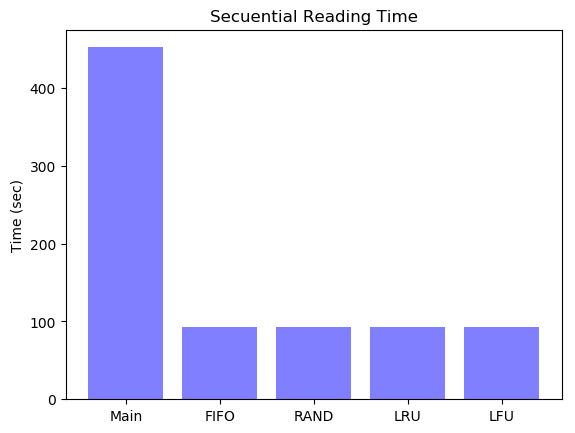

In [5]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
 
objects = ('Main', 'FIFO', 'RAND', 'LRU', 'LFU')
y_pos = np.arange(len(objects))
performance = [451.99813199043274, 93.10810494422913, 93.05641198158264, 93.01834893226624, 93.0265200138092]
 
plt.bar(y_pos, performance, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('Time (sec)')
plt.title('Secuential Reading Time')
 
plt.show()
plt.savefig('secuentialTime.png')

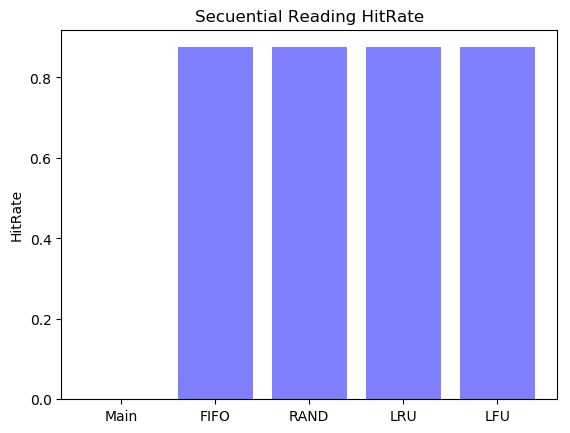

In [6]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
 
objects = ('Main', 'FIFO', 'RAND', 'LRU', 'LFU')
y_pos = np.arange(len(objects))
performance = [0, 0.875, 0.875, 0.875, 0.875]
 
plt.bar(y_pos, performance, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('HitRate')
plt.title('Secuential Reading HitRate')
 
plt.show()